# Проверка гипотез

В ходе изучения переменных мы заметили некоторые интересные закономерности, которые проверим в этой части работы.

In [17]:
import pandas as pd
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [127]:
df = pd.read_csv('final_data.csv', index_col='Unnamed: 0')
df.head()

,Модель,Цена,Год выпуска,Пробег,Привод,ЛС,Тип двигателя,Тип кузова,Коробка передач,Объём двигателя,Цвет,Марка,Класс,Налог
0,Kia Carnival IV,4379000,2020,26000,передний,202,Дизель,минивэн,автомат,2.2,чёрный,Kia,4,14443
1,Kia Carnival III,2519000,2018,43000,передний,202,Дизель,минивэн,автомат,2.2,чёрный,Kia,3,13130
2,Tesla Model X Plaid I Рестайлинг,15490000,2022,70,полный,1020,Электро,внедорожник 5 дв.,автомат,2.4,чёрный,Tesla,5,0
3,LADA (ВАЗ) Vesta I,1330000,2021,9000,передний,113,Бензин,седан,вариатор,1.6,белый,LADA,2,2825
4,McLaren 765LT,59500000,2021,1311,задний,765,Бензин,купе,робот,4.0,фиолетовый,McLaren,5,344250


## Гипотеза о равенстве цен машин разных цветов

Предположение о том, что большинство людей не сильно любят экспериментировать и выделяться и предпочитают такие консервативные цвет, как белый или черный, является весьма логичным. Проверим, приводит ли к формированию дисконта при продаже необычный цвет машины. Формально гипотезы буду звучать так:
$$
H_0 : \mu_{bw} = \mu_{oth} 
$$
$$
H_1 : \mu_{bw} > \mu_{oth}
$$

In [129]:
df1 = df.loc[df['Цена'] <= 40*10**6] # Избавимся от машин дороже 40 млн руб

In [130]:
bnw = np.logical_or(df1['Цвет'] == 'чёрный', df1['Цвет'] == 'белый')
bnw_price = df1[bnw]['Цена'] # белые и черные машины
oth_price = df1[~bnw]['Цена'] # остальные

Text(0, 0.5, 'Количество наблюдений')

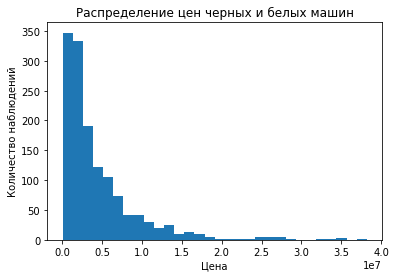

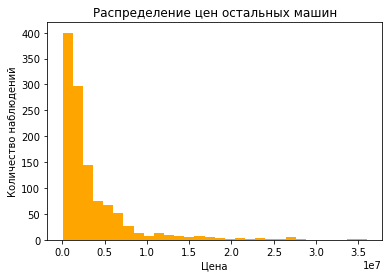

In [131]:
plt.title('Распределение цен черных и белых машин')
plt.hist(bnw_price, bins=30)
plt.xlabel('Цена')
plt.ylabel('Количество наблюдений')

plt.figure()
plt.title('Распределение цен остальных машин')
plt.hist(oth_price, bins=30, color='orange')
plt.xlabel('Цена')
plt.ylabel('Количество наблюдений')

Обе гистограммы чем-то напоминаются экспоненциальное распределение, однако как можно заметить, у нас все еще достаточно много наблюдений с очень высокой ценой и тяжелый правый хвост в следствие этого.

## Асимптотический z-тест

Поскольку мы имеем достаточно много наблюдений, а разность мат. ожиданий распределена асимптотически нормально, можно начать проверку именно с этого теста. 

$$
Z_{obs} = \frac{\overline{X}_{bw} - \overline{X}_{oth} - 0}{\sqrt{\frac{\hat{\sigma_{bw^2}}}{n_{bw}} + \frac{\hat{\sigma_{oth^2}}}{n_{oth}}}}
$$

In [125]:
z_obs = (bnw_price.mean() - oth_price.mean()) / np.sqrt(np.var(bnw_price, ddof=1)/len(bnw_price) + np.var(oth_price, ddof=1)/len(oth_price))

1 - sts.norm.cdf(z_obs) # p-value

2.6365523597693397e-07

Получается, что гипотеза о равенства отвергается при любом уровне значимости

Чтобы закрепить этот результат, можно провести тест бутстрапом t-статистики.

## Бутстрап t-статистики

In [126]:
sts.ttest_ind(bnw_price, oth_price, equal_var=False, permutations=10000)

Ttest_indResult(statistic=5.016099428877058, pvalue=9.999000099990002e-05)

Как можно заметить, и в этом тесте p-value низок для всех разумных уровнях значимости.

Таким образом, гипотеза о равенстве цен машин разных цветов отвергается.

# Доля машин с МКПП стала ниже в течение последних 5 лет

Обычно машины оборудованные механической коробкой передач обходятся дешевле в производстве, но также есть маленькая доля машин c МКПП, которые делаются таковыми для аутентичности. Тем не менее, мы предполагаем, что все большая доля выпускаемых машин переходит к автоматической коробке. Проверим эту гипотезу (p - доля машин с МКПП):

$$
H_0: p_{new} = p_{old}
$$
$$
H_1: p_{new} < p_{old}
$$

In [144]:
old = df.loc[df['Год выпуска'] < 2018]
new = df.loc[df['Год выпуска'] >= 2018]

old_p = (old['Коробка передач'] == 'механика').mean()
new_p = (new['Коробка передач'] == 'механика').mean()

print(old_p, new_p)

0.19709355131698456 0.07481125600549074


Начнем, как обычно, с асимптотического z-теста.

## Z-test

$$
Z_{obs} = \frac{\hat{p}_{new} - \hat{p}_{old} - 0}{\sqrt{\frac{\hat{\sigma_{old}^2}}{n_{old}} + \frac{\hat{\sigma_{new}^2}}{n_{new}}}}
$$

In [145]:
z_obs = (new_p - old_p) / np.sqrt(np.var(old['Коробка передач'] == 'механика', ddof=1) / len(old) + np.var(new['Коробка передач'] == 'механика', ddof=1) / len(new))

sts.norm.cdf(z_obs)

4.837200291120715e-19

P-value получился очень маленьким, поэтому гипотеза о равенстве отвергается.

## Бутстрап t-статистики

In [160]:
sts.ttest_ind(bnw_price, oth_price, equal_var=False, permutations=10000)

Ttest_indResult(statistic=5.016099428877058, pvalue=9.999000099990002e-05)

Этот тест также отвергает гипотезу о равенстве.